In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mltools import plot_data, plot_frontiere, make_grid, gen_arti

In [47]:

def mse(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return np.transpose(x@w-y)**2

def reglog(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    y=np.where(y==-1,0,1) # On convertit les -1 en 0
    X=np.exp(-(x@w))
    return (np.sum((np.log(1+X)))-np.transpose(np.log(X))@(1-y))/len(x)

def mse_grad(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    return 2*np.transpose(x)@(x@w-y)/len(x)

def reglog_grad(w,x,y):
    y = y.reshape(-1,1)
    w = w.reshape(-1,1)
    x = x.reshape(y.shape[0],w.shape[0])
    y=np.where(y==-1,0,y)
    pred=1/(1+np.exp(-(x@w)))
    return -np.transpose(x)@(y-pred)/len(x)
    

def check_fonctions():
    ## On fixe la seed de l'aléatoire pour vérifier les fonctions
    np.random.seed(0)
    datax, datay = gen_arti(epsilon=0.1)
    wrandom = np.random.randn(datax.shape[1],1)
    assert(np.isclose(mse(wrandom,datax,datay).mean(),0.54731,rtol=1e-4))
    assert(np.isclose(reglog(wrandom,datax,datay).mean(), 0.57053,rtol=1e-4))
    assert(np.isclose(mse_grad(wrandom,datax,datay).mean(),-1.43120,rtol=1e-4))
    assert(np.isclose(reglog_grad(wrandom,datax,datay).mean(),-0.42714,rtol=1e-4))
    np.random.seed()

check_fonctions()

In [54]:
def grad_check(f,f_grad,N): 
    datax, datay = gen_arti(epsilon=0.1,nbex=N)
    wrandom = np.random.randn(datax.shape[1],1)
    h=np.random.rand(len(datax[0]))*0.001

    f_x_plus_h=f(wrandom,datax+h,datay).mean() # Vraie valeur de f(x+h)
    approx=f(wrandom,datax,datay).mean()+h@f_grad(wrandom,datax,datay) # On approxime f(x+h) par Taylor

    return f_x_plus_h-approx.mean() # On regarde la différence

print(grad_check(mse,mse_grad,100),grad_check(reglog,reglog_grad,100))

0.001169844313190449 0.00039564978379419413


In [108]:
def descente_gradient(datax,datay,f_loss,f_grad,eps=10e-3,iter=100):
    datay = datay.reshape(-1,1)
    w=np.array([0]*len(datax[0]))
    w_list=[w]
    f_values=[f_loss(w_list[0],datax,datay).mean()]
    for i in range(iter):
        w=w-eps*f_grad(w,datax,datay).reshape(1,-1)
        w_list.append(w)
        f_values.append(f_loss(w_list[-1],datax,datay).mean())
    w_opt=w_list[np.argmin(f_values)].reshape(len(datax[0]),)

    return w_opt,w_list,f_values

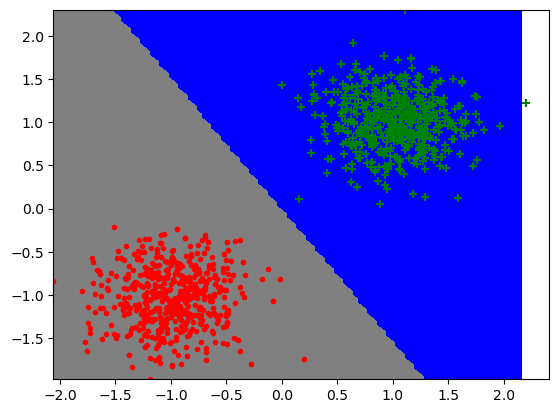

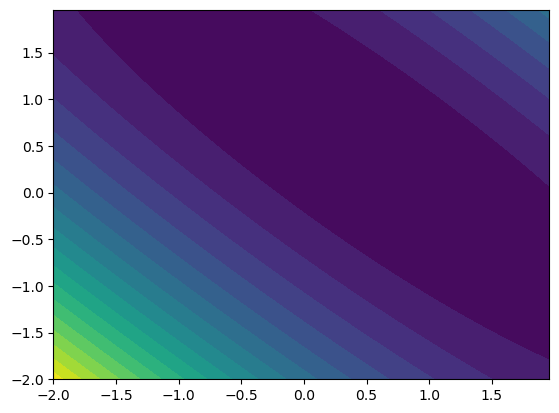

In [64]:
if __name__=="__main__":
    ## Tirage d'un jeu de données aléatoire avec un bruit de 0.1
    datax, datay = gen_arti(epsilon=0.1)
    ## Fabrication d'une grille de discrétisation pour la visualisation de la fonction de coût
    grid, x_grid, y_grid = make_grid(xmin=-2, xmax=2, ymin=-2, ymax=2, step=100)
    
    plt.figure()
    ## Visualisation des données et de la frontière de décision pour un vecteur de poids w
    w  = np.random.randn(datax.shape[1],1)
    plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
    plot_data(datax,datay)

    ## Visualisation de la fonction de coût en 2D
    plt.figure()
    plt.contourf(x_grid,y_grid,np.array([mse(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)
    

In [147]:
# Test de l'implémentation de la descente de gradient sur le pb à 2 gaussiennes
# Cas 1 : avec régression linéaire

datax, datay = gen_arti(epsilon=0.1)
datay=datay.reshape(1,-1)
N=len(datax)//2

datax_train,datax_test=datax[:N],datax[N:] # Séparation en données d'entrainement et de test
datay_train,datay_test=datay[:,:N],datay[:,N:]
w_opt,w_list,f_values=descente_gradient(datax_train,datay_train,mse,mse_grad) # Apprentissage

y_hat=np.where(datax_test@w_opt>0,1,-1) # Prédiction
score=np.where(y_hat==datay_test,1,0).mean() # Comparaison entre labels prédits et véritables
print(score) # Affichage de l'accuracy

# La régression linéaire permet de parfaitement classer les deux gaussiennes.

# Cas 2 : avec régression logistique

w_opt,w_list,f_values=descente_gradient(datax_train,datay_train,reglog,reglog_grad) # Apprentissage

y_hat=np.where(datax_test@w_opt>0,1,-1) # Prédiction
score=np.where(y_hat==datay_test,1,0).mean() # Comparaison entre labels prédits et véritables
print(score) # Affichage de l'accuracy

# De même, la régression logistique permet à nouveau de correctement classer tous les points.

[ 1.09469868 -1.04600774  1.37572939 -0.86574744  0.52075495  0.96255108
 -1.39135669 -0.80067193 -1.03659133  0.90695824] [[ 1. -1.  1. -1.  1.  1. -1. -1. -1.  1.]]
1.0
[ 0.91840647 -0.87660546  1.15228664 -0.72532796  0.43754077  0.80616221
 -1.16573946 -0.67119381 -0.86870247  0.76013377] [[ 1. -1.  1. -1.  1.  1. -1. -1. -1.  1.]]
1.0
